<a href="https://colab.research.google.com/github/Lithium-spirit/Galaxy-Morphological-Classifier-and-Anisotropy-in-Spin-directions-in-Universe./blob/main/Gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, measure
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.transform import rescale
from scipy.ndimage import median_filter, gaussian_filter1d
from scipy.signal import find_peaks
from sklearn.linear_model import LinearRegression
from math import atan2, degrees


In [ ]:
image_path = "/content/Screenshot 2025-07-19 084355.jpg"
galaxy = io.imread(image_path)
if galaxy.ndim == 3:
    galaxy_gray = rgb2gray(galaxy)
else:
    galaxy_gray = galaxy
galaxy_gray.shape

(192, 194)

In [ ]:
threshold_value = threshold_otsu(galaxy_gray)
binary_mask = galaxy_gray > threshold_value
labeled_mask = measure.label(binary_mask, connectivity=2)
min_size = 1000
large_object_labels = [region.label for region in measure.regionprops(labeled_mask) if region.area > min_size]
large_objects_mask = np.isin(labeled_mask, large_object_labels)


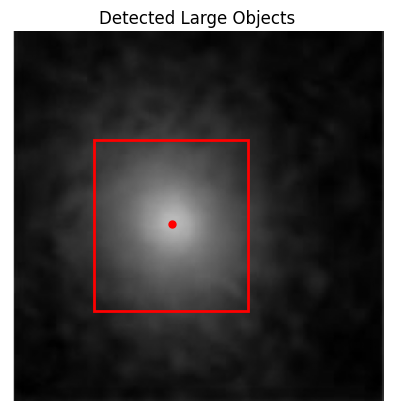

In [ ]:
fig, ax = plt.subplots()
ax.imshow(galaxy_gray, cmap='gray')
for region in measure.regionprops(labeled_mask):
    if region.area > min_size:
        y0, x0 = region.centroid
        ax.plot(x0, y0, 'ro', markersize=5)
        minr, minc, maxr, maxc = region.bbox
        rect = plt.Rectangle((minc, minr), maxc - minc, maxr - minr,
                             fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
plt.title('Detected Large Objects')
plt.axis('off')
plt.show()

In [ ]:
def detect_objects_and_find_centers(image, min_size=1000):
    if image.ndim == 3:
        image_gray = rgb2gray(image)
    else:
        image_gray = image
    threshold_value = threshold_otsu(image_gray)
    binary_mask = image_gray > threshold_value
    labeled_mask = measure.label(binary_mask, connectivity=2)
    large_object_labels = [region.label for region in measure.regionprops(labeled_mask) if region.area > min_size]
    large_objects_mask = np.isin(labeled_mask, large_object_labels)

    results = []
    for label_id in large_object_labels:
        object_mask = (labeled_mask == label_id)
        coords = np.argwhere(object_mask)
        y_coords = coords[:, 0]
        x_coords = coords[:, 1]
        v = np.median(x_coords)
        w = np.median(y_coords)
        S = object_mask.sum()
        max_median = -np.inf
        best_center = (v, w)
        v_int = int(round(v))
        w_int = int(round(w))
        for dv in range(-2, 3):
            for dw in range(-2, 3):
                x_cand = v_int + dv
                y_cand = w_int + dw
                if (y_cand - 2 < 0 or y_cand + 3 > image_gray.shape[0] or
                    x_cand - 2 < 0 or x_cand + 3 > image_gray.shape[1]):
                    continue
                window = image_gray[y_cand-2:y_cand+3, x_cand-2:x_cand+3]
                median_val = np.median(window)
                if median_val > max_median:
                    max_median = median_val
                    best_center = (x_cand, y_cand)
        distance = np.sqrt((best_center[0] - v)**2 + (best_center[1] - w)**2)
        threshold = 0.1 / np.sqrt(S / np.pi)
        if distance < threshold:
            Ox, Oy = best_center
        else:
            Ox, Oy = v, w
        results.append({
            'label': label_id,
            'area': S,
            'pixel_mass_center': (v, w),
            'galaxy_center': (Ox, Oy)
        })
    return results, object_mask, image_gray

results, labelemask, image_gray = detect_objects_and_find_centers(galaxy)
results

[{'label': 2,
  'area': np.int64(5167),
  'pixel_mass_center': (np.float64(84.0), np.float64(99.0)),
  'galaxy_center': (np.float64(84.0), np.float64(99.0))}]

In [ ]:
def compute_galaxy_properties(object_mask, galaxy_center):

    coords = np.argwhere(object_mask)  # (y, x)

    # Center coordinates (Ox, Oy)
    Ox, Oy = galaxy_center

    # distances from center to all foreground pixels
    distances = np.sqrt((coords[:, 1] - Ox)**2 + (coords[:, 0] - Oy)**2)


    radius = distances.max()

    # To find major axis:

    angle_bins = np.linspace(-np.pi, np.pi, 360)
    max_length = 0
    major_axis_angle = 0

    for angle in angle_bins:
        ux = np.cos(angle)
        uy = np.sin(angle)
        projections = (coords[:, 1] - Ox) * ux + (coords[:, 0] - Oy) * uy
        max_proj = projections.max()
        min_proj = projections.min()
        length = max_proj - min_proj
        if length > max_length:
            max_length = length
            major_axis_angle = angle

    major_axis_length = max_length

    # Minor axis is perpendicular to major axis
    minor_axis_angle = major_axis_angle + np.pi/2
    ux_minor = np.cos(minor_axis_angle)
    uy_minor = np.sin(minor_axis_angle)
    projections_minor = (coords[:, 1] - Ox) * ux_minor + (coords[:, 0] - Oy) * uy_minor
    minor_axis_length = projections_minor.max() - projections_minor.min()

    # Ellipticity
    ellipticity = minor_axis_length / major_axis_length if major_axis_length != 0 else 0

    # Position angle in degrees
    position_angle = degrees(major_axis_angle)
    if position_angle < 0:
        position_angle += 180
    elif position_angle >= 180:
        position_angle -= 180

    return {
        'radius': radius,
        'major_axis_length': major_axis_length,
        'minor_axis_length': minor_axis_length,
        'ellipticity': ellipticity,
        'position_angle': position_angle
    }




In [ ]:

def compute_radial_intensity_plot(image_gray, galaxy_center, radius):
    Ox, Oy = galaxy_center
    scale_factor = 1.0
    if radius > 100:
        scale_factor = 100.0 / radius
        image_gray = rescale(image_gray, scale_factor, anti_aliasing=True, channel_axis=None)
        Ox *= scale_factor
        Oy *= scale_factor
        radius = 100

    radial_intensity_plot = np.zeros((35, 360))
    radial_distances = np.linspace(1, 35, 35)

    for theta in range(360):
        theta_rad = np.deg2rad(theta)
        sin_theta = np.sin(theta_rad)
        cos_theta = np.cos(theta_rad)

        for i, r in enumerate(radial_distances):

            x = Ox + sin_theta * (r*100/35)
            y = Oy - cos_theta * (r*100/35)

            x_int = int(round(x))
            y_int = int(round(y))
            x_min = max(x_int - 2, 0)
            x_max = min(x_int + 3, image_gray.shape[1])
            y_min = max(y_int - 2, 0)
            y_max = min(y_int + 3, image_gray.shape[0])

            window = image_gray[y_min:y_max, x_min:x_max]
            if window.size == 0:
                median_val = 0
            else:
                median_val = np.median(window)

            radial_intensity_plot[ i-1,theta] = median_val
            '''




    # Smooth each horizontal line

    for theta in range(360):
        radial_intensity_plot[ :, theta] = median_filter(
            radial_intensity_plot[ :, theta], size=50, mode='nearest'
        )'''


    return radial_intensity_plot, scale_factor


In [ ]:
def detect_peaks_morhac(intensity_curve, sigma=10, threshold=0.05, iterations=1):
    smoothed = intensity_curve.copy()
    for _ in range(iterations):
        smoothed = gaussian_filter1d(smoothed, sigma=sigma)
    peaks, properties = find_peaks(smoothed, height=threshold)
    return peaks, properties['peak_heights'], smoothed

In [ ]:
def analyze_spirality_and_bars(radial_intensity_plot, radius, ellipticity):
    from sklearn.linear_model import LinearRegression
    import numpy as np

    # four radial ranges as fractions of the radius
    radial_ranges = [
        (0.1, 0.45),
        (0.2, 0.55),
        (0.3, 0.65),
        (0.4, 0.75)
    ]
    n_radii = radial_intensity_plot.shape[0]
    radial_indices_ranges = [
        (int(frac_start * n_radii), int(frac_end * n_radii))
        for frac_start, frac_end in radial_ranges
    ]

    # peaks from all ranges
    all_peaks = []
    for r_start, r_end in radial_indices_ranges:
        for r_idx in range(r_start, r_end):
            intensity_curve = radial_intensity_plot[r_idx, :]
            peaks, heights, smoothed_curve = detect_peaks_morhac(intensity_curve)
            for peak in peaks:
                all_peaks.append((peak, r_idx))

    if len(all_peaks) <= 0:
        if ellipticity > 0.8:
            return 'edge-on', {'reason': 'no peaks, ellipticity > 0.8'}, all_peaks
        else:
            return 'elliptical', {'reason': 'no peaks, ellipticity <= 0.8'}, all_peaks

    # Linear regression to find arms
    sorted_peaks = sorted(all_peaks, key=lambda p: p[0])

    groups = []
    current_group = [sorted_peaks[0]]
    for peak in sorted_peaks[1:]:
        # threshold
        if abs(peak[0] - current_group[-1][0]) <= 10:
            current_group.append(peak)
        else:
            groups.append(current_group)
            current_group = [peak]
    groups.append(current_group)  # Add the final group

    arms = []
    for group in groups:
        if len(group) >= 10:
            #y = np.array([radial_plot[p[1],p[0]]for p in group])
            y = np.array([p[1] for p in group])
            X = np.array([p[0] for p in group]).reshape(-1,1)
            model = LinearRegression()
            model.fit(X, y)
            slope = model.coef_[0]
            std_resid = np.std(y - model.predict(X))
            arms.append({'slope': slope, 'std': std_resid, 'count': len(group)})
    # Ganalyzer spiral/elliptical rules
    if not arms:
        if ellipticity > 0.8:
            classification = 'edge-on'
        else:
            classification = 'elliptical'
    elif len(arms) == 1:
        slope_abs = abs(arms[0]['slope'])
        std = arms[0]['std']
        if slope_abs > 0.5 or (std < 2 and slope_abs > 0.35):
            classification = 'spiral'
        else:
            classification = 'elliptical'
    else:
        slopes = [abs(a['slope']) for a in arms]
        stds = [a['std'] for a in arms]
        if (all(s > 0.5 for s in slopes) or any(s > 0.7 for s in slopes)):
            classification = 'spiral'
        elif any(std < 2 and s > 0.35 for s, std in zip(slopes, stds)):
            classification = 'spiral'
        else:
            classification = 'elliptical'

    # Bar detection (0.5r to 1.0r)
    r_start_bar = int(0.5 * n_radii)
    r_end_bar = n_radii
    vertical_lines = radial_intensity_plot[:, r_start_bar:r_end_bar]
    increases = []
    for row in vertical_lines:
        increases.append(np.sum(np.diff(row) > 0) >= (len(row) // 2))
    bar_fraction = np.mean(increases)
    has_bar = bar_fraction >= 0.5

    if has_bar and classification == 'spiral':
        classification = 'barred spiral'

    details = {
        'arms': arms,
        'bar_fraction': bar_fraction,
        'has_bar': has_bar,
        'ellipticity': ellipticity
    }

    return classification, details, all_peaks


Galaxy 2 properties: {'radius': np.float64(48.16637831516918), 'major_axis_length': np.float64(91.60711130414003), 'minor_axis_length': np.float64(77.68887021636648), 'ellipticity': np.float64(0.8480659318951307), 'position_angle': 53.64902506963787}
Galaxy 2 classification: spiral
Details: {'arms': [{'slope': np.float64(-0.25000000000000017), 'std': np.float64(1.6887986310766985), 'count': 21}, {'slope': np.float64(-0.6158770806658133), 'std': np.float64(1.9098772845388372), 'count': 10}, {'slope': np.float64(0.06603683153396363), 'std': np.float64(4.947181401586763), 'count': 73}, {'slope': np.float64(-1.1251819505094618), 'std': np.float64(3.1707192193366587), 'count': 11}, {'slope': np.float64(-0.22231139646869985), 'std': np.float64(4.245833887937603), 'count': 15}, {'slope': np.float64(-0.03252459158783127), 'std': np.float64(5.365353025118499), 'count': 45}], 'bar_fraction': np.float64(0.02857142857142857), 'has_bar': np.False_, 'ellipticity': np.float64(0.8480659318951307)}


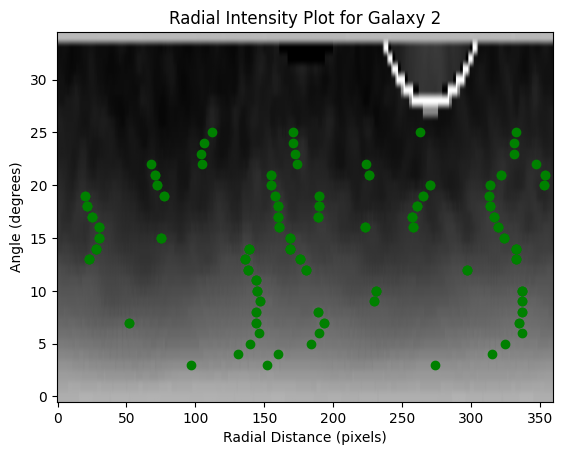

(np.float64(84.0), np.float64(99.0))


In [ ]:

for obj in results:
    label_id = obj['label']
    galaxy_center = obj['galaxy_center']
    object_mask = labelemask
    props = compute_galaxy_properties(object_mask, galaxy_center)
    print(f"Galaxy {label_id} properties:", props)
    radial_plot, scale = compute_radial_intensity_plot(image_gray, galaxy_center, props['radius'])
    classification, details ,all_peaks= analyze_spirality_and_bars(radial_plot, props['radius'], props['ellipticity'])
    print(f"Galaxy {label_id} classification: {classification}")
    print(f"Details: {details}")
    # visualizing radial intensity plot
    plt.figure()

    x=[]
    for i in range(len(all_peaks)):
        x.append(all_peaks[i][1])
    y=[]
    for i in range(len(all_peaks)):
        y.append(all_peaks[i][0])
    plt.scatter(y, x, color='green', label='Peaks')
    plt.imshow(radial_plot, aspect='auto', cmap='gray',origin='lower')

    plt.xlabel('Radial Distance (pixels)')
    plt.ylabel('Angle (degrees)')
    plt.title(f'Radial Intensity Plot for Galaxy {label_id}')
    plt.show()
    print(galaxy_center)


In [ ]:
clock=0
anti=0
slope=0
if classification == "spiral" or classification=='barred spiral':

    if 'arms' in details and len(details['arms']) > 0:
      for i in range(len(details['arms'])):

        if details['arms'][i]['slope'] > 0:
          anti+=1

        else:
          clock+=1

    if clock>anti:
        print("clockwise")
    elif anti>clock:
        print("anticlockwise")
    else:
      for i in range(len(details['arms'])):
        slope=slope+details['arms'][i]['slope']
      if slope>0:
        print('anticlockwise')
      else:
        print('clockwise')






else:
  print("Spin direction could not be determined (no arms detected).")
print(slope)

clockwise
0


[(7, 19), (10, 22), (14, 26)]


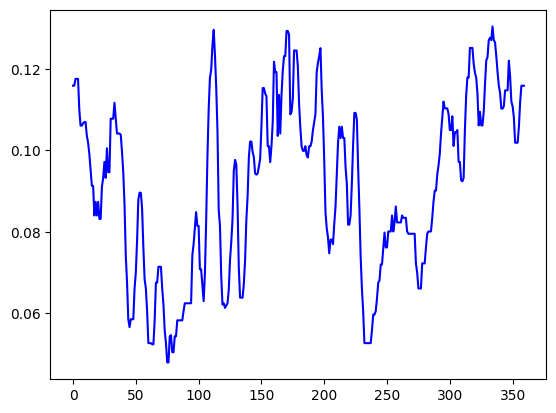

In [ ]:
radial_ranges = [
        #(0.1, 0.45),
        (0.2, 0.55),
        (0.3, 0.65),
        (0.4, 0.75)
    ]
n_radii = radial_plot.shape[0]
radial_indices_ranges = [(int(frac_start * n_radii), int(frac_end * n_radii)) for frac_start, frac_end in radial_ranges]

for r_start, r_end in radial_indices_ranges:
        for r_idx in range(r_start, r_end):
            intensity_curve = radial_plot[r_idx, :]

plt.plot(intensity_curve, color='blue', label='Original Curve')
k=0
for i, (r_start, r_end) in enumerate(radial_indices_ranges):
  for r_idx in range(r_start, r_end):
    k+=1
print(radial_indices_ranges)


/tmp/ipython-input-583-92613988.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


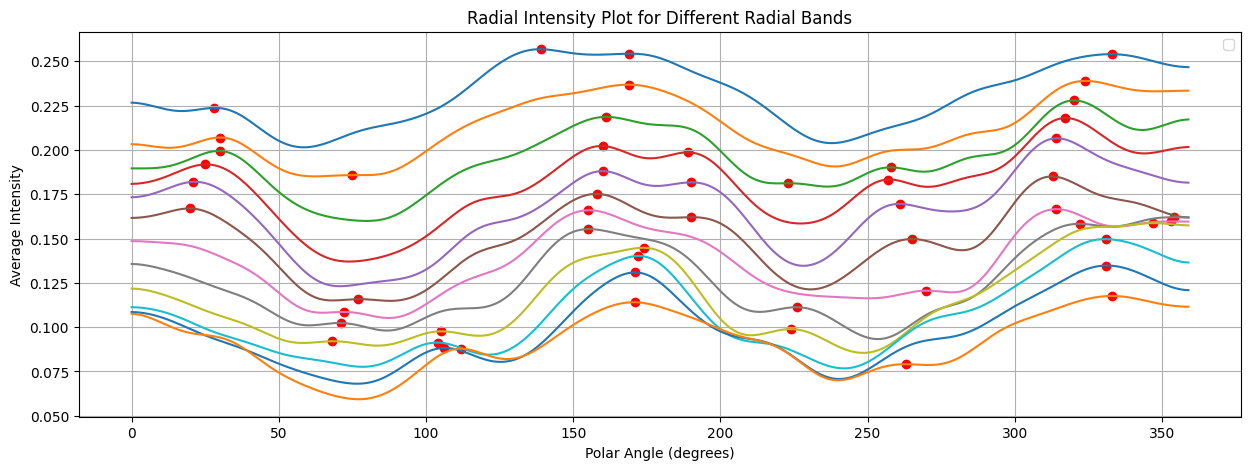

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


if radial_plot.shape[1] == 35:
    radial_plot = radial_plot.T
# Define radial ranges as fractions of radial bins
radial_ranges = [
    #(0.1, 0.45),
    #(0.2, 0.55),
    #(0.3, 0.65),
    (0.4, 0.75)
]

n_radii = radial_plot.shape[0]
radial_indices_ranges = [(int(frac_start * n_radii), int(frac_end * n_radii)) for frac_start, frac_end in radial_ranges]

# Plot setup
plt.figure(figsize=(15, 5))

for i, (r_start, r_end) in enumerate(radial_indices_ranges):

    for r_idx in range(r_start, r_end):
      intensity_curve = radial_plot[r_idx, :]
      peaks, heights, smoothed_curve = detect_peaks_morhac(intensity_curve)
      plt.plot(np.arange(360), smoothed_curve)
      plt.scatter(peaks, heights, color='red')

plt.xlabel("Polar Angle (degrees)")
plt.ylabel("Average Intensity")
plt.title("Radial Intensity Plot for Different Radial Bands")
plt.legend()
plt.grid(True)
plt.show()

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


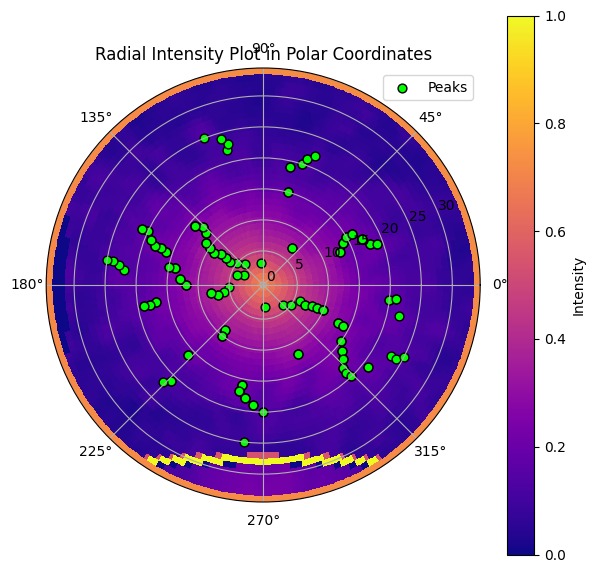

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


radii = np.arange(radial_plot.shape[0])
angles = np.deg2rad(np.arange(radial_plot.shape[1]))
theta_grid, r_grid = np.meshgrid(angles, radii)


peak_radii = [p[1] for p in all_peaks]
peak_thetas_rad = [np.deg2rad(p[0]) for p in all_peaks]

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(7,7))
c = ax.pcolormesh(theta_grid, r_grid, radial_plot, shading='auto', cmap='plasma')

ax.scatter(peak_thetas_rad, peak_radii, color='lime', label='Peaks', s=40, marker='o', edgecolor='black')
fig.colorbar(c, ax=ax, orientation='vertical', label='Intensity')
ax.set_title("Radial Intensity Plot in Polar Coordinates")
ax.legend()
plt.show()


In [ ]:
#for running on a dataset
'''
import os
from skimage import io
import pandas as pd

# Add your galaxy analysis functions here...
# compute_galaxy_properties(), compute_radial_intensity_plot(), analyze_spirality_and_bars()

def get_direction_of_spin(arms):
    # Example placeholder function, replace with actual logic if you have it
    if not arms:
        return "N/A"
    slope = arms[0]['slope']
    return "clockwise" if slope < 0 else "counterclockwise"

def classify_all_images_in_folder(folder_path):
    result = []

    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.jpg', '.png', '.jpeg', '.tif', '.bmp')):
            image_path = os.path.join(folder_path, filename)
            galaxy_image = io.imread(image_path)
            results, labelemask, image_gray = detect_objects_and_find_centers(galaxy_image)
            for obj in results:
              label_id = obj['label']
              galaxy_center = obj['galaxy_center']
              object_mask = labelemask
              props = compute_galaxy_properties(object_mask, galaxy_center)

              radial_plot, scale = compute_radial_intensity_plot(image_gray, galaxy_center, props['radius'])
              classification, details ,all_peaks= analyze_spirality_and_bars(radial_plot, 100, props['ellipticity'])
              if classification == "spiral" or classification == "barred spiral":
                # Check the first (or main) arm's slope
                spin = get_direction_of_spin(details.get('arms', []))
              else:
                spin="none"
              result.append({
                'image_name': filename,
                'classification': classification,
                'direction_of_spin': spin
                 })

    # Convert to pandas DataFrame for easy saving/printing
    df = pd.DataFrame(result)
    print(df)
    df.to_csv("galaxy_classification_results.csv", index=False)

# Usage
image_folder = '/content/drive/MyDrive/Anisotropy'
classify_all_images_in_folder(image_folder)
'''

'\nimport os\nfrom skimage import io\nimport pandas as pd\n\n# Add your galaxy analysis functions here...\n# compute_galaxy_properties(), compute_radial_intensity_plot(), analyze_spirality_and_bars()\n\ndef get_direction_of_spin(arms):\n    # Example placeholder function, replace with actual logic if you have it\n    if not arms:\n        return "N/A"\n    slope = arms[0][\'slope\']\n    return "clockwise" if slope < 0 else "counterclockwise"\n\ndef classify_all_images_in_folder(folder_path):\n    result = []\n\n    for filename in os.listdir(folder_path):\n        if filename.lower().endswith((\'.jpg\', \'.png\', \'.jpeg\', \'.tif\', \'.bmp\')):\n            image_path = os.path.join(folder_path, filename)\n            galaxy_image = io.imread(image_path)\n            results, labelemask, image_gray = detect_objects_and_find_centers(galaxy_image)\n            for obj in results:\n              label_id = obj[\'label\']\n              galaxy_center = obj[\'galaxy_center\']\n           